<h1> Прогноз поведения клиента

**Описание проекта:**

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.


**Цель проекта:**

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет, основываясь на исторических данных о поведении клиентов и расторжении договоров с банком. Построим модель с предельно большим значением F1-меры, доведя метрику до 0.59.

**Ход исследования:**

1. [Обзор данных](#1)
2. [Предобработка данных](#2)
3. [Исследование задачи](#3)
4. [Борьба с дисбалансом](#4)
5. [Тестирование модели](#5)
6. [Выводы](#6)

<a id='1'></a>

<h2> Обзор данных

Импортируем необходимые библиотеки для будущей работы. Считаем данные из csv-файла в переменную `data` и изучим их.

Путь к файлу: `/datasets/Churn.csv`

In [1]:
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# импорты модулей текущего проекта
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
    plot_confusion_matrix,
    roc_curve
)
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# настройки
warnings.filterwarnings('ignore')

In [2]:
def get_data_info(data):
    print('Длина датасета:', len(data), '\nРазмер датасета:', data.shape, '\n')
    display(data.info(), 
            data.head(), 
            data.describe(include='all').T, 
            data.corr().style.background_gradient(cmap='coolwarm'))

In [3]:
try:
    data = pd.read_csv('C:\jupyter projects\Churn.csv')
    sns.set_style("darkgrid")
except:
    data = pd.read_csv('/datasets/Churn.csv')
    sns.set_style("darkgrid")

In [4]:
get_data_info(data)

Длина датасета: 10000 
Размер датасета: (10000, 14) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0
CustomerId,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
Tenure,9091.0,NaN,NaN,NaN,4.99769,2.894723,0.0,2.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


<h3>Вывод:

Из полученных данных следует:

- В датасете 10  000 объектов и 14 признаков
- Целевой признак - `Exited`. Он имеет всего 2 возможных значения - 0 или 1, поэтому перед нами задача бинарной классификации, которую мы будем решать с помощью метода машинного обучения «Обучение с учителем»
- У признака `Tenure` заметны пропущенные значения
- В описательной статистике не замечено выбивающихся значений
- Признаки между собой не сильно скоррелированы, поэтому проблема мультиколлиниарности отсутствует

<a id='2'></a>

<h2> Предобработка данных

Проведем предобработку данных:

- Приведем названия признаков к стилю `snake`
- Изучим и заполним пропуски
- Рассмотрим датасет на наличие дубликатов
- Изучим уникальные значения

<h3>Названия столбцов

In [5]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]

In [6]:
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

<h3>Пропуски

Мы знаем, что у признака `tenure` имеются пропуски. Изучим их процент от всех объектов признака.

In [7]:
print('Процент пропущенных значений в "tenure":', 
      "{:.2%}".format(data['tenure'].isna().mean()))

Процент пропущенных значений в "tenure": 9.09%


Пропусков немного. Возможно они возникли из-за того, что клиент пришел в банк недавно.

Есть несколько вариантов для борьбы с ними:

1. Удалить пропущенные значения
2. Заменить пропущенные значения медианой 
3. Заменить пропущенные значения минимальным значением

В данном случае остановимя на замене пропусков медианным значением.

In [8]:
data['tenure'] = data['tenure'].fillna(data['tenure'].median())

In [9]:
data.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

<h3>Дубликаты

Проверим датасет на явные дубликаты.

In [10]:
data.duplicated().sum()

0

Проверим датасет на неявные дубликаты.

In [11]:
data[['customer_id', 'surname','row_number']].duplicated(keep=False).sum()

0

Удалим столбцы `row_number`, `customer_id`, `surname`, так как они не имеют информативной ценности для алгоритма.

In [12]:
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1);

In [13]:
data.shape

(10000, 11)

<h3>Уникальные значения

In [14]:
display(data['geography'].unique(), data['gender'].unique())

array(['France', 'Spain', 'Germany'], dtype=object)

array(['Female', 'Male'], dtype=object)

<h3> Вывод

По итогам предобработки данных, мы:

- Привели названия признаков к стилю `snake`
- Заменили пропуски в `tenure` на минимальное значение - 0
- Не нашли дубликатов
- Узнали что признак `geography` принимает 3 значения - `France`, `Spain` и `Germany`; признак `gender` - `Male` и `Female`

<a id='3'></a>

<h2> Исследование задачи

Подготовим данные для машинного обучения.

- Объявим две переменные:
  - сохраним в `features` признаки
  - сохраним в `target` целевой признак
  
- Разделим данные на тренировочную, валидационную и тестовую выборки

- Применим One-Hot Encoding к признакам `geography` и `gender`

- Масштабируем признаки

Обучим модели `Random Forest`, `Decision Tree` и `Logistic Regression` без учета дисбаланса. Изучим их score-значения и построим ROC-кривую.

<h3> Подготовка данных

Объявим две переменные:
- features
- target

In [15]:
features = data.drop('exited', axis=1)
target = data['exited']

Взглянем на их размерность.

In [16]:
features.shape, target.shape

((10000, 10), (10000,))

Разделим данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1

In [17]:
# обучающая и (тестовая и валидационная) выборки
(features_train, features_test,
 target_train, target_test) = train_test_split(features, 
                                               target, 
                                               test_size = 0.4, 
                                               random_state=12345)

# валидационная и тестовая выборки 
(features_valid, features_test,
 target_valid, target_test) = train_test_split(features_test, 
                                               target_test, 
                                               test_size = 0.5, 
                                               random_state=12345)

Проверим их размерность.

In [18]:
print(f'Train: {features_train.shape, target_train.shape}')
print(f'Valid: {features_valid.shape, target_valid.shape}')
print(f'Test: {features_test.shape, target_test.shape}')

Train: ((6000, 10), (6000,))
Valid: ((2000, 10), (2000,))
Test: ((2000, 10), (2000,))


Применим OHE к категориальным признакам.

In [19]:
# выделим категориальные признаки
categorial = ['geography', 'gender']

In [20]:
# обучим модель на тренировочной выборке
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
ohe.fit(features_train[categorial])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [21]:
# # энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тренировочную
features_train[
    ohe.get_feature_names_out()
] = ohe.transform(features_train[categorial])

# удалим незакодированные категориальные признаки
features_train = features_train.drop(categorial, axis=1)

In [22]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем валидационную
features_valid[
    ohe.get_feature_names_out()
] = ohe.transform(features_valid[categorial])

# удалим незакодированные категориальные признаки
features_valid = features_valid.drop(categorial, axis=1)

In [23]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
features_test[
    ohe.get_feature_names_out()
] = ohe.transform(features_test[categorial])

# удалим незакодированные категориальные признаки
features_test = features_test.drop(categorial, axis=1)

Выведем на экран получившиеся таблицы.

In [24]:
display(features_train.head())
display(features_valid.head())
display(features_test.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7479,567,35,8.0,153137.74,1,1,0,88659.07,0.0,1.0,1.0
3411,711,37,8.0,113899.92,1,0,0,80215.20,0.0,0.0,0.0
6027,850,44,3.0,140393.65,2,0,1,186285.52,1.0,0.0,1.0
1247,512,24,6.0,0.00,2,1,0,37654.31,0.0,0.0,1.0
3716,665,27,2.0,147435.96,1,0,0,187508.06,1.0,0.0,0.0


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
8532,585,35,2.0,0.00,2,1,0,98621.04,0.0,0.0,0.0
5799,625,45,3.0,0.00,1,1,1,184474.15,0.0,0.0,0.0
5511,667,32,0.0,103846.65,1,1,0,20560.69,1.0,0.0,1.0
7365,568,36,10.0,153610.61,1,1,1,54083.80,0.0,1.0,0.0
7367,606,42,10.0,0.00,2,1,0,177938.52,0.0,1.0,1.0


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7041,438,38,2.0,0.00,2,1,0,136859.55,0.0,0.0,1.0
5709,644,39,9.0,0.00,1,1,0,3740.93,0.0,0.0,0.0
7117,564,31,5.0,121461.87,1,1,1,20432.09,0.0,1.0,1.0
7775,628,40,10.0,0.00,2,1,0,103832.58,0.0,1.0,1.0
8735,728,30,10.0,114835.43,1,0,1,37662.49,0.0,0.0,1.0


Стандартизируем признаки `credit_score`, `age`, `tenure`, `balance`, `num_of_products`, `estimated_salary`, так как из-за их разного масштаба алгоритм может решить, что какой-то из них важнее остальных.

In [25]:
# выделим нужные численные признаки
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

In [26]:
# обучим модель на тренировочной выборке
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [27]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем все выборки
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Выведем на экран получившиеся таблицы.

In [28]:
display(features_train.head())
display(features_valid.head())
display(features_test.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7479,-0.886751,-0.373192,1.082277,1.232271,-0.891560,1,0,-0.187705,0.0,1.0,1.0
3411,0.608663,-0.183385,1.082277,0.600563,-0.891560,0,0,-0.333945,0.0,0.0,0.0
6027,2.052152,0.480939,-0.737696,1.027098,0.830152,0,1,1.503095,1.0,0.0,1.0
1247,-1.457915,-1.417129,0.354288,-1.233163,0.830152,1,0,-1.071061,0.0,0.0,1.0
3716,0.130961,-1.132419,-1.101690,1.140475,-0.891560,0,0,1.524268,1.0,0.0,0.0


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
8532,-0.699824,-0.373192,-1.101690,-1.233163,0.830152,1,0,-0.015173,0.0,0.0,0.0
5799,-0.284431,0.575842,-0.737696,-1.233163,-0.891560,1,1,1.471724,0.0,0.0,0.0
5511,0.151731,-0.657902,-1.829679,0.438711,-0.891560,1,0,-1.367107,1.0,0.0,1.0
7365,-0.876366,-0.278288,1.810266,1.239884,-0.891560,1,1,-0.786517,0.0,1.0,0.0
7367,-0.481743,0.291132,1.810266,-1.233163,0.830152,1,0,1.358533,0.0,1.0,1.0


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7041,-2.226392,-0.088482,-1.101690,-1.233163,0.830152,1,0,0.647083,0.0,0.0,1.0
5709,-0.087120,0.006422,1.446272,-1.233163,-0.891560,1,0,-1.658410,0.0,0.0,0.0
7117,-0.917905,-0.752805,-0.009707,0.722307,-0.891560,1,1,-1.369334,0.0,1.0,1.0
7775,-0.253277,0.101325,1.810266,-1.233163,0.830152,1,0,0.075086,0.0,1.0,1.0
8735,0.785204,-0.847708,1.810266,0.615625,-0.891560,0,1,-1.070919,0.0,0.0,1.0


<h3> Модели без учёта дисбаланса

Взглянем на соотношение объектов целевого признака.

0    7963
1    2037
Name: exited, dtype: int64

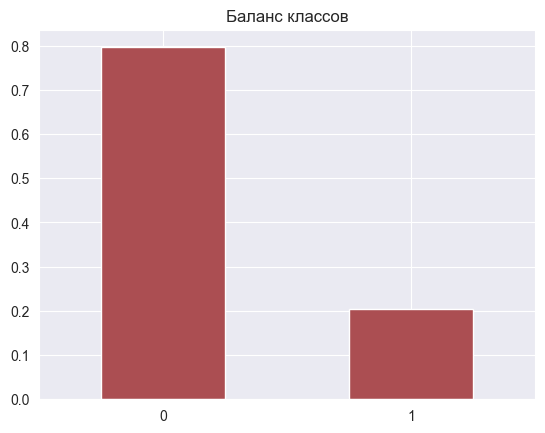

In [29]:
data['exited'].value_counts(normalize=1).plot(kind='bar', color='#ab4e52', rot=0)
plt.title('Баланс классов')
data['exited'].value_counts()

Заметен явный перевес объектов, означающих уход клиента. Позитивных значений меньше примерно в 4 раза.

Пока что рассмотрим несколько моделей обучения без учёта дисбаланса — `Decision Tree`, `Random Forest` и `Logistic Regression`. Исследуем их качества. Для подбора гиперпараметров используем циклы. Посмотрим, сколько времени на обучение занимает каждая модель.

In [30]:
# функция подбора гиперпараметров
def model_params(model, def_features, def_target, weight):
    if model == RandomForestClassifier:
        rf_f1_score = 0
        rf_depth = 0
        rf_est = 0
        for est in range(10, 101, 10):     
            for depth in range(1, 15):         
                model = RandomForestClassifier(
                    random_state=12345, 
                    n_estimators=est, 
                    max_depth=depth,
                    class_weight=weight
                )
                model.fit(def_features, def_target)
                preds = model.predict(features_valid)
                f1 = f1_score(target_valid, preds)
                if rf_f1_score < f1:
                    rf_f1_score = f1
                    rf_depth = depth
                    rf_est = est
        return print(
            f'Оптимальная глубина дерева: {rf_depth}\
            \nОптимальное число деревьев: {rf_est}\
            \nF1 score: {rf_f1_score}'
        )

    elif model == DecisionTreeClassifier:
        dt_f1_score = 0
        dt_depth = 0
        for depth in range(1,15):
            model = DecisionTreeClassifier(
                random_state=12345, 
                max_depth=depth,
                class_weight=weight
            )
            model.fit(def_features, def_target)
            preds = model.predict(features_valid)
            f1 = f1_score(target_valid, preds)
            if dt_f1_score < f1:
                dt_f1_score = f1
                dt_depth = depth
        return print(
            f'Оптимальная глубина дерева: {dt_depth}\nF1 score: {dt_f1_score}'
        )

In [31]:
# функция вывода score-значений
def print_result(preds):
    print('Accuracy:', accuracy_score(target_valid, preds),
          '\nF1 score:', f1_score(target_valid, preds),
          '\nRecall score:', recall_score(target_valid, preds),
          '\nPrecision score:', precision_score(target_valid, preds))

In [32]:
# функция для графика roc_curve и roc_auc_score
def roc_plot(rf, dt, lr):
    
    rf_prob = rf.predict_proba(features_valid)
    rf_prob = rf_prob[:, 1]

    dt_prob = dt.predict_proba(features_valid)
    dt_prob = dt_prob[:, 1]

    lr_prob = lr.predict_proba(features_valid)
    lr_prob = lr_prob[:, 1]
    
    print('Random Forest ROC-AUC score:', roc_auc_score(target_valid, rf_prob))
    print('Decision Tree ROC-AUC score:', roc_auc_score(target_valid, dt_prob))
    print('Logistic Regression ROC-AUC score:', roc_auc_score(target_valid, lr_prob))

    rf_fpr, rf_tpr, thresholds = roc_curve(target_valid, rf_prob)
    dt_fpr, dt_tpr, thresholds = roc_curve(target_valid, dt_prob)
    lr_fpr, lr_tpr, thresholds = roc_curve(target_valid, lr_prob)

    plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot(rf_fpr, rf_tpr, color='#ac2359')
    plt.plot(dt_fpr, dt_tpr, color='#2896ff')
    plt.plot(lr_fpr, lr_tpr, color='#95a532')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(('Random Forest','Decision Tree','Logistic Regression'),
               loc='upper left') 

    plt.plot([0, 1], [0, 1], linestyle='--', color='#382f61')
    plt.show()

<h4>Random forest

In [33]:
model_params(RandomForestClassifier, features_train, target_train, None)

Оптимальная глубина дерева: 12            
Оптимальное число деревьев: 90            
F1 score: 0.5896656534954408


In [34]:
%%time

rf_model = RandomForestClassifier(random_state=12345, 
                                  max_depth=12, 
                                  n_estimators=90)
rf_model.fit(features_train, target_train)
rf_preds = rf_model.predict(features_valid)

CPU times: total: 375 ms
Wall time: 422 ms


In [35]:
print_result(rf_preds)

Accuracy: 0.865 
F1 score: 0.5896656534954408 
Recall score: 0.46411483253588515 
Precision score: 0.8083333333333333


<h4>Decision tree

In [36]:
model_params(DecisionTreeClassifier, features_train, target_train, None)

Оптимальная глубина дерева: 6
F1 score: 0.5696969696969697


In [37]:
%%time

dt_model = DecisionTreeClassifier(random_state=12345, max_depth=6)
dt_model.fit(features_train, target_train)
dt_preds = dt_model.predict(features_valid)

CPU times: total: 0 ns
Wall time: 12.1 ms


In [38]:
print_result(dt_preds)

Accuracy: 0.858 
F1 score: 0.5696969696969697 
Recall score: 0.44976076555023925 
Precision score: 0.7768595041322314


<h4>Logistic Regression

In [39]:
%%time

lr_model = LogisticRegression(random_state=12345, solver='liblinear')
lr_model.fit(features_train, target_train)
lr_preds = lr_model.predict(features_valid)

CPU times: total: 0 ns
Wall time: 13.4 ms


In [40]:
print_result(lr_preds)

Accuracy: 0.802 
F1 score: 0.33108108108108103 
Recall score: 0.23444976076555024 
Precision score: 0.5632183908045977


<h4> Roc curve

Random Forest ROC-AUC score: 0.8483976433440803
Decision Tree ROC-AUC score: 0.8164631712023421
Logistic Regression ROC-AUC score: 0.7587512627102753


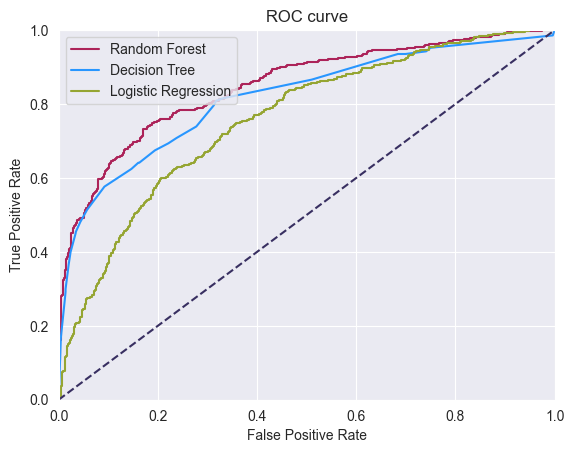

In [41]:
roc_plot(rf_model, dt_model, lr_model)

 <h3> Вывод

- Мы применили OHE и масштабирование и подготовили данные для моделей
- Была выявлена проблема дисбаланса данных
- Самая быстрая скорость обучения оказалась у `Logistic Regression`, самая медленная - у `Random Forest`
- Лучше всего себя показывает модель `Random Forest`, выдавая значение `F1 score: 0.5896656534954408` с гиперпараметрами:
  - `max_depth=12`
  - `n_estimators=90`

<a id='4'></a>

<h2> Борьба с дисбалансом

Улучшим качество моделей, учитывая дисбаланс классов. 

Для этого:
- Построим матрицу ошибок для каждой модели
- Применим к каждой модели 3 способа борьбы с дисбалансом:
  - Увеличение выборки
  - Уменьшение выборки
  - Взвешивание классов
- Изучим их score-значения и построим ROC-кривую.

<h3>Confusion Matrix

Построим Confusion Matrix, чтобы детально рассмотреть где модели совершают ошибки.

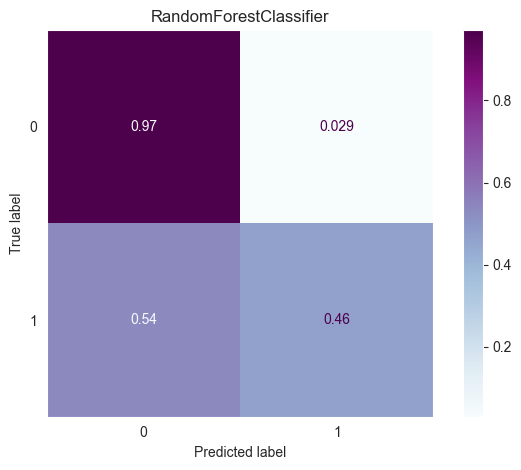

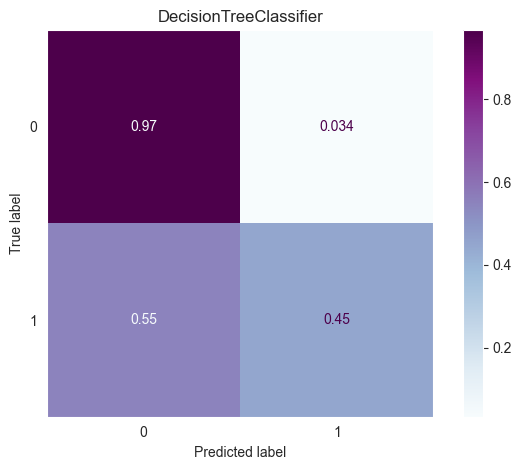

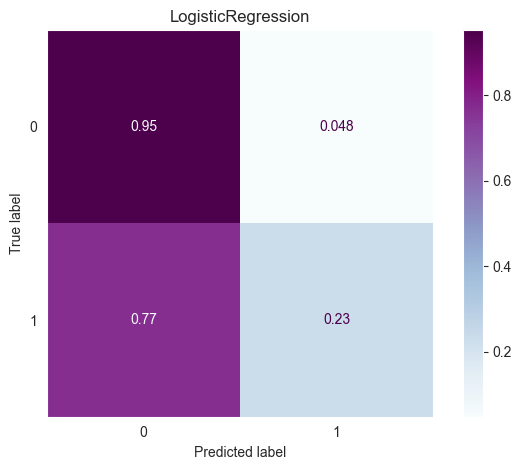

In [42]:
all_models = rf_model, dt_model, lr_model

for model in all_models:
    fig, ax = plt.subplots()
    plot_confusion_matrix(model, features_valid, target_valid, 
                          normalize='true', cmap='BuPu', ax=ax)
    ax.title.set_text(type(model).__name__)
    plt.grid()
    plt.tight_layout() 
    plt.show()

Все модели довольно хорошо справляются с предсказыванием TN(true negative) значений, однако качество предсказаний довольно сильно проседает на TP(true positive) - модели чаще выдают негативные значения, когда те на самом деле позитивные.

<h3> Увеличение выборки

Напишем функцию и применим её для увеличения тренировочной выборки. Обучим на ней модели и посмотрим на значения F1 score и AUC_ROC.

In [43]:
# функция увеличения выборки
oversample = SMOTE(random_state=12345)
features_upsampled, target_upsampled = oversample.fit_resample(
    features_train, target_train
)

Проверим размерность изначальной тренировочной выборки и полученной в ходе апсемплинга.

In [44]:
print('Изначальная выборка', features_train.shape, target_train.shape)
print('Апсемплированная выборка', features_upsampled.shape, target_upsampled.shape)

Изначальная выборка (6000, 11) (6000,)
Апсемплированная выборка (9608, 11) (9608,)


Посмотрим на баланс классов.

0    4804
1    4804
Name: exited, dtype: int64

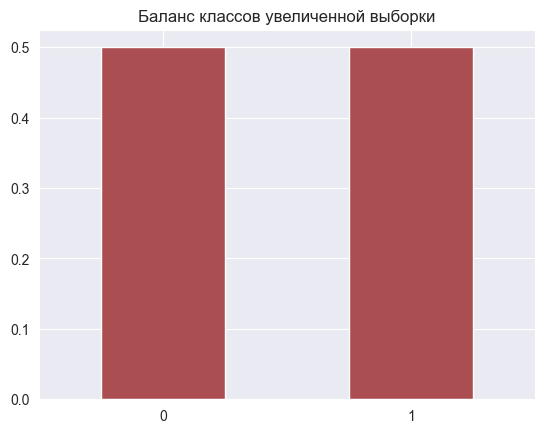

In [45]:
target_upsampled.value_counts(normalize=1).plot(kind='bar', color='#ab4e52', rot=0)
plt.title('Баланс классов увеличенной выборки')
target_upsampled.value_counts()

<h4> Random forest

In [46]:
model_params(RandomForestClassifier, features_upsampled, target_upsampled, None)

Оптимальная глубина дерева: 7            
Оптимальное число деревьев: 80            
F1 score: 0.6134453781512605


In [47]:
%%time

rf_model_up = RandomForestClassifier(random_state=12345, max_depth=7, n_estimators=80)
rf_model_up.fit(features_upsampled, target_upsampled)
rf_preds = rf_model_up.predict(features_valid)

CPU times: total: 312 ms
Wall time: 455 ms


In [48]:
print_result(rf_preds)

Accuracy: 0.816 
F1 score: 0.6134453781512605 
Recall score: 0.6985645933014354 
Precision score: 0.5468164794007491


<h4> Decision Tree

In [49]:
model_params(DecisionTreeClassifier, features_upsampled, target_upsampled, None)

Оптимальная глубина дерева: 5
F1 score: 0.5748116254036598


In [50]:
%%time

dt_model_up = DecisionTreeClassifier(random_state=12345, max_depth=5)
dt_model_up.fit(features_upsampled, target_upsampled)
df_preds = dt_model_up.predict(features_valid)

CPU times: total: 31.2 ms
Wall time: 17.6 ms


In [51]:
print_result(dt_preds)

Accuracy: 0.858 
F1 score: 0.5696969696969697 
Recall score: 0.44976076555023925 
Precision score: 0.7768595041322314


<h4> Logistic regression

In [52]:
%%time

lr_model_up = LogisticRegression(random_state=12345, solver='liblinear')
lr_model_up.fit(features_upsampled, target_upsampled)
lr_preds = lr_model_up.predict(features_valid)

CPU times: total: 0 ns
Wall time: 12 ms


In [53]:
print_result(lr_preds)

Accuracy: 0.7005 
F1 score: 0.48138528138528136 
Recall score: 0.6650717703349283 
Precision score: 0.37720488466757124


<h4> Roc curve

Random Forest ROC-AUC score: 0.8417982808993523
Decision Tree ROC-AUC score: 0.8256030764763882
Logistic Regression ROC-AUC score: 0.7515107156467193


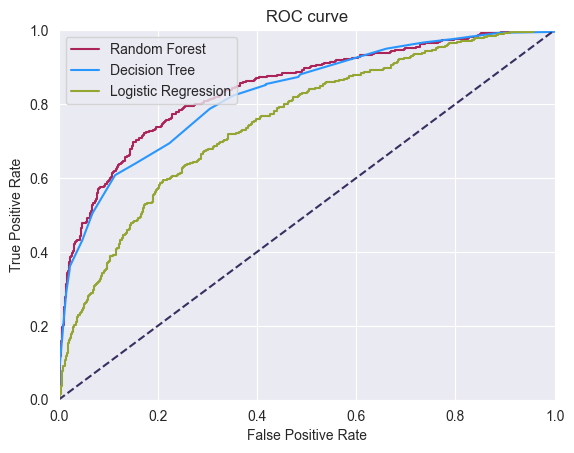

In [54]:
roc_plot(rf_model_up, dt_model_up, lr_model_up)

<h3> Уменьшение выборки

Напишем функцию и применим её для уменьшения тренировочной выборки. Обучим на ней модели и посмотрим на значения F1 score и AUC_ROC.

In [55]:
# функция уменьшения выборки
rus = RandomUnderSampler(random_state=12345)
features_downsampled, target_downsampled = rus.fit_resample(
    features_train, target_train
)

Проверим размерность изначальной тренировочной выборки и полученной в ходе даунсемплинга.

In [56]:
print('Изначальная выборка', features_train.shape, target_train.shape)
print('Апсемплированная выборка', features_downsampled.shape, target_downsampled.shape)

Изначальная выборка (6000, 11) (6000,)
Апсемплированная выборка (2392, 11) (2392,)


Посмотрим на баланс классов.

0    1196
1    1196
Name: exited, dtype: int64

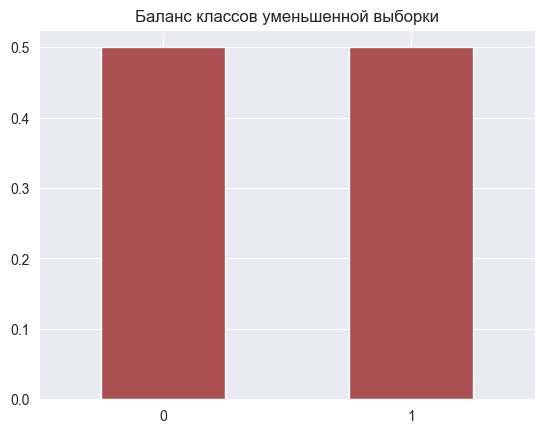

In [57]:
target_downsampled.value_counts(normalize=1).plot(kind='bar', color='#ab4e52', rot=0)
plt.title('Баланс классов уменьшенной выборки')
target_downsampled.value_counts()

<h4> Random Forest

In [58]:
model_params(RandomForestClassifier, features_downsampled, target_downsampled, None)

Оптимальная глубина дерева: 6            
Оптимальное число деревьев: 100            
F1 score: 0.6015180265654648


In [59]:
%%time

rf_model_down = RandomForestClassifier(random_state=12345,
                                       max_depth=6,
                                       n_estimators=100)
rf_model_down.fit(features_downsampled, target_downsampled)
rf_preds = rf_model_down.predict(features_valid)

CPU times: total: 156 ms
Wall time: 172 ms


In [60]:
print_result(rf_preds)

Accuracy: 0.79 
F1 score: 0.6015180265654648 
Recall score: 0.7583732057416268 
Precision score: 0.49842767295597484


<h4> Decision Tree

In [61]:
model_params(DecisionTreeClassifier, features_downsampled, target_downsampled, None)

Оптимальная глубина дерева: 5
F1 score: 0.5943204868154158


In [62]:
%%time

dt_model_down = DecisionTreeClassifier(random_state=12345, max_depth=5)
dt_model_down.fit(features_downsampled, target_downsampled)
dt_preds = dt_model_down.predict(features_valid)

CPU times: total: 0 ns
Wall time: 5.18 ms


In [63]:
print_result(dt_preds)

Accuracy: 0.8 
F1 score: 0.5943204868154158 
Recall score: 0.7009569377990431 
Precision score: 0.5158450704225352


<h4> Logistic regression

In [64]:
%%time

lr_model_down = LogisticRegression(random_state=12345, solver='liblinear')
lr_model_down.fit(features_downsampled, target_downsampled)
lr_preds = lr_model_down.predict(features_valid)

CPU times: total: 0 ns
Wall time: 3.72 ms


In [65]:
print_result(lr_preds)

Accuracy: 0.701 
F1 score: 0.4853700516351119 
Recall score: 0.6746411483253588 
Precision score: 0.3790322580645161


<h4> Roc curve

Random Forest ROC-AUC score: 0.8470623461308137
Decision Tree ROC-AUC score: 0.8241029464247908
Logistic Regression ROC-AUC score: 0.7620524561605139


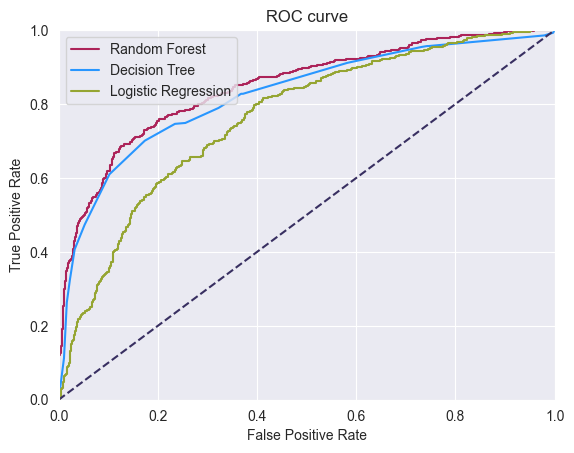

In [66]:
roc_plot(rf_model_down, dt_model_down, lr_model_down)

<h3> Взвешивание классов

Для взвешивания классов укажем гиперпараметр `class_weight="balanced"` у каждой модели. Обучим модели и посмотрим на значения F1 score и AUC_ROC.

<h4>Random Forest

In [67]:
model_params(RandomForestClassifier, features_train, target_train, 'balanced')

Оптимальная глубина дерева: 9            
Оптимальное число деревьев: 90            
F1 score: 0.6284403669724771


In [68]:
%%time

rf_model_balanced = RandomForestClassifier(random_state=12345,
                                           class_weight='balanced', 
                                           max_depth=9,
                                           n_estimators=90)
rf_model_balanced.fit(features_train, target_train)
rf_preds = rf_model_balanced.predict(features_valid)

CPU times: total: 281 ms
Wall time: 379 ms


In [69]:
print_result(rf_preds)

Accuracy: 0.838 
F1 score: 0.6284403669724771 
Recall score: 0.6555023923444976 
Precision score: 0.6035242290748899


<h4>Decision Tree

In [70]:
model_params(DecisionTreeClassifier, features_train, target_train, 'balanced')

Оптимальная глубина дерева: 5
F1 score: 0.5963791267305644


In [71]:
%%time

dt_model_balanced = DecisionTreeClassifier(random_state=12345, 
                                           class_weight='balanced', 
                                           max_depth=5)
dt_model_balanced.fit(features_train, target_train)
dt_preds = dt_model_balanced.predict(features_valid)

CPU times: total: 0 ns
Wall time: 13.9 ms


In [72]:
print_result(dt_preds)

Accuracy: 0.8105 
F1 score: 0.5963791267305644 
Recall score: 0.6698564593301436 
Precision score: 0.5374280230326296


<h4>Logistic Regression

In [73]:
%%time

lr_model_balanced = LogisticRegression(random_state=12345, 
                                       solver='liblinear', 
                                       class_weight='balanced')
lr_model_balanced.fit(features_train, target_train)
lr_preds = lr_model_balanced.predict(features_valid)

CPU times: total: 0 ns
Wall time: 10.5 ms


In [74]:
print_result(lr_preds)

Accuracy: 0.702 
F1 score: 0.4888507718696398 
Recall score: 0.6818181818181818 
Precision score: 0.3810160427807487


<h4>Roc curve

Random Forest ROC-AUC score: 0.8539475196438401
Decision Tree ROC-AUC score: 0.8310244134068074
Logistic Regression ROC-AUC score: 0.7637310291013133


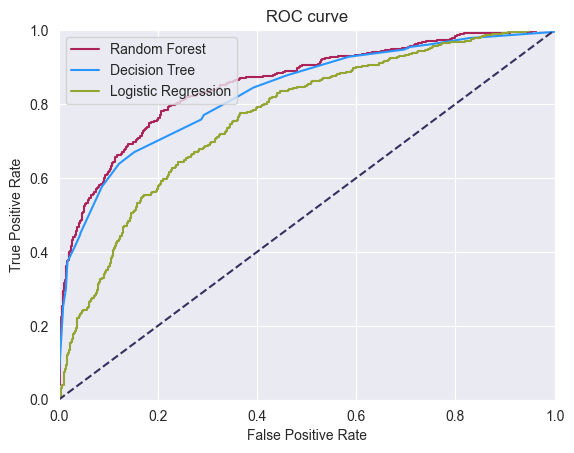

In [75]:
roc_plot(rf_model_balanced, dt_model_balanced, lr_model_balanced)

<h3> Вывод

- `Logistic Regression` в каждом случае обучается быстрее остальных моделей

- При увеличении выборки, значения F1 score у моделей следующие:
  - `Random Forest`: 0.6134453781512605 
  - `Decision Tree`: 0.5696969696969697 
  - `Logistic Regression`: 0.48138528138528136 
- При уменьшении выборки, значения F1 score у моделей следующие:
  - `Random Forest`: 0.6015180265654648
  - `Decision Tree`: 0.5943204868154158
  - `Logistic Regression`: 0.4853700516351119 
- При взвешивании классов выборки, значения F1 score у моделей следующее:
  - `Random Forest`: 0.6284403669724771  
  - `Decision Tree`: 0.5963791267305644
  - `Logistic Regression`: 0.4888507718696398

- При апсемплинге и даунсемплинге модель `Decision Tree` имеет наибольшее значение `accuracy`

- Лучше всего себя показывает модель `Random Forest`, выдавая значение `F1 score: 0.6284403669724771` с гиперпараметрами:
  - `class_weight="balanced"`
  - `max_depth=9`
  - `n_estimators=90`

<a id='5'></a>

<h2> Тестирование модели

Объединим тестовую и валидационную выборки, чтобы улучшить качество модели.

In [76]:
features_test = pd.concat([features_test, features_valid], axis=0, ignore_index=True)
target_test = pd.concat([target_test, target_valid], axis=0, ignore_index=True)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
👍  Тоже хорошее решение.
</div>  
    


In [77]:
features_test.shape, target_test.shape

((4000, 11), (4000,))

Протестируем модель

In [78]:
%%time

rf_final = RandomForestClassifier(random_state=12345,
                                  class_weight='balanced',
                                  max_depth=9,
                                  n_estimators=90)
rf_final.fit(features_train, target_train)
rf_preds = rf_final.predict(features_test)

CPU times: total: 359 ms
Wall time: 381 ms


In [79]:
print('Accuracy:', accuracy_score(target_test, rf_preds),
      '\nF1 score:', f1_score(target_test, rf_preds), 
      '\nRecall score:', recall_score(target_test, rf_preds), 
      '\nPrecision score:', precision_score(target_test, rf_preds))

Accuracy: 0.83275 
F1 score: 0.6192373363688106 
Recall score: 0.6468489892984542 
Precision score: 0.5938864628820961


AUC-ROC tree: 0.8543946499422785


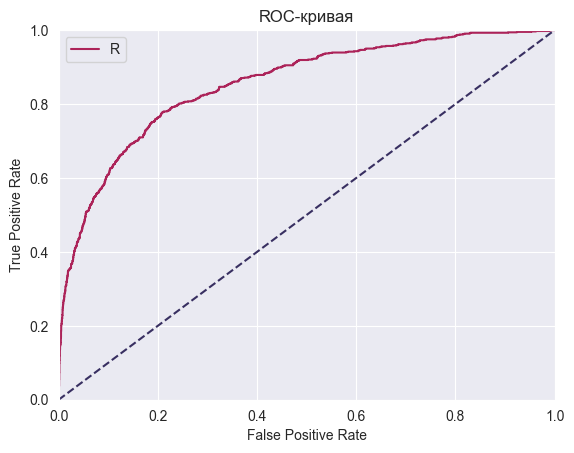

In [80]:
rf_probs = rf_final.predict_proba(features_test)
rf_probs = rf_probs[:, 1]
print('AUC-ROC tree:', roc_auc_score(target_test, rf_probs))

rf_final_fpr, rf_final_tpr, thresholds = roc_curve(target_test, rf_probs)


plt.figure()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(rf_final_fpr, rf_final_tpr, color='#ac2359')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend('Random Forest')

plt.plot([0, 1], [0, 1], linestyle='--', color='#382f61')
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
👍 По коду все отлично. По результату также достигаем нужного качества, но, как описал выше, с кросс-валидацией тут включается процесс рандомности. 
</div>  
    


Проверим модель на адекватность с помощью `DummyClassifier()`, который делает прогнозы с использованием простых правил и не генерирует никаких ценных сведений о данных. В гиперпараметрах укажем значение `strategy=constant, constant=1`.

In [81]:
dc_model = DummyClassifier(random_state=12345, strategy='constant', constant=1)
dc_model.fit(features_train, target_train)
f1_score(dc_model.predict(features_test), target_test)

0.3474488741995455

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Здесь в дамми-модели я бы предсказал везде «1». Условно говоря, если предсказываем ноль, моделируем ситуацию, когда акцию с бонусами для удержания клиентов решили не проводить. Если предсказываем единицу − решили раздать бонусы вообще всем клиентам. Если в дамми-модели предсказываем по единице, можно подсчитать F1, она не будет зануляться.
    
`dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
f1_score(dummy_model.predict(features_test), target_test)`


       
</div>


<div class="alert alert-info">
Изменил гиперпараметры на strategy='constant', constant=1
</div>

Значение F1 score у нашей модели выше, чем у `DummyClassifier()`, а значит мы можем назвать модель адекватной.

Также построим Confusion Matrix, чтобы детально рассмотреть где модель совершает ошибки.

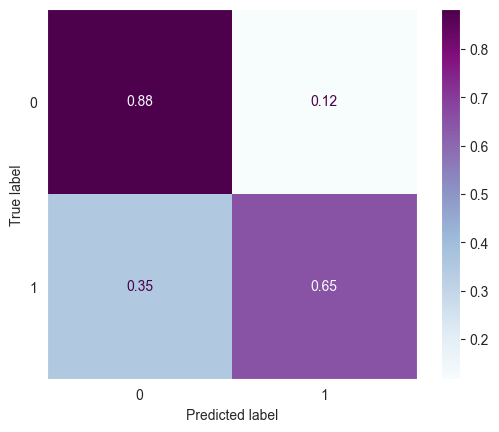

In [82]:
plot_confusion_matrix(rf_final, features_test, target_test, cmap='BuPu', normalize='true')
plt.grid()

Модель чаще ошибается на позитивных значениях, угадывая их как негативные.

<a id='6'></a>

<h2> Выводы

<h3> Цель проекта

Спрогнозировать, уйдёт клиент из банка в ближайшее время или нет, основываясь на исторических данных о поведении клиентов и расторжении договоров с банком. Построить модель с предельно большим значением F1-меры.

<h3> Исходные данные

**Признаки**

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

**Целевой признак**

- `Exited` — факт ухода клиента

<h3> Выводы

В обзоре данных мы заметили пропуски в данных; изучили корреляцию между признаками и пришли к выводу, что проблема мультиколлинеарности отсутствует.

В предобработке данных были приведены к стилю `snake` названия признаков и заполнены пропущенные значения в `tenure`. Дубликатов не было найдено. Были удалены признаки `row_number`, `customer_id` и `surname`.

В ходе исследования задачи, мы:
- Подготовили данные для моделей, создав тренировочную, валидационную и тестовую выборки в соотношении 3:1:1; применив One-Hot Encoding к `geography` и `gender`; стандартизировав `credit_score`, `age`, `tenure`, `balance`, `num_of_products` и `estimated_salary`

- Выявили дисбаланс классов(позитивных значений целевого признака было в 4 раза больше, чем негативных)

- Обучили модели без учёта дисбаланса классов, однако получили низкие показатели полноты и точности, а соответственно и низкое качество взвешенной величины F1

- Для борьбы с дисбалансом применили несколько методов:
  - Увеличение выборки
  - Уменьшение выборки
  - Взвешивание классов

- Лучший результат показала модель `Random Forest` с гиперпараметрами:
  - `class_weight="balanced"`, 
  - `max_depth=9`
  - `n_estimators=90`
- Показатели модели:
  - `Accuracy: 0.838`
  - `F1 score: 0.6284403669724771` 
  - `Recall score: 0.6555023923444976` 
  - `Precision score: 0.6035242290748899`

Найдя лучшую модель для нашей задачи, мы протестировали её на тестовой выборке, которую перед этим объединили с валидационной, и получили следующие показатели:

- `Accuracy: 0.83275` 
- `F1 score: 0.6192373363688106` 
- `Recall score: 0.6468489892984542` 
- `Precision score: 0.5938864628820961`

В конце мы проверили модель на адекватность с помощью метода `DummyClassifier()` и убедились в том, что модель адекватно работает.

Поставленная цель была достигнута, так как мы построили модель с метрикой, большей чем 0.59